In [4]:
pip install folium

   ---------------------------------------- 0.0/110.9 kB ? eta -:--:--
   ------------------------------------ --- 102.4/110.9 kB 3.0 MB/s eta 0:00:01
   ---------------------------------------- 110.9/110.9 kB 3.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [22]:
import simpy
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import folium
from folium.plugins import HeatMap
from scipy.spatial import cKDTree
import numpy as np


In [23]:
df_fires=pd.read_csv('/Users/spud/Documents/MSDS 460/MSDS 460 Term Project/Infrared_Spread_Data.csv')

In [24]:
df_damage=pd.read_csv('/Users/spud/Documents/MSDS 460/MSDS 460 Term Project/POSTFIRE_MASTER_DATA_SHARE_8915263461538710042.csv', low_memory=False)

In [25]:
with open('/Users/spud/Documents/MSDS 460/MSDS 460 Term Project/Infrared_Spread_Data.csv', 'r', encoding='utf-8') as f:
    for _ in range(10):  # Print first 10 lines
        print(f.readline())


latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight,type

40.39546,-79.85742,329.89,0.39,0.36,2018-01-01,0716,N,VIIRS,n,2,261.97,3.85,N,2

40.75602,-81.43361,325.36,0.39,0.36,2018-01-01,0716,N,VIIRS,n,2,256.88,2.46,N,0

41.62996,-87.36842,308.96,0.42,0.45,2018-01-01,0716,N,VIIRS,n,2,264.66,2.58,N,3

41.4677,-83.36609,321.33,0.43,0.38,2018-01-01,0716,N,VIIRS,n,2,261.54,2.89,N,0

41.2244,-83.21004,323.6,0.42,0.38,2018-01-01,0716,N,VIIRS,n,2,258.69,3.07,N,2

41.68151,-87.42147,298.91,0.42,0.45,2018-01-01,0716,N,VIIRS,n,2,261.5,0.88,N,3

41.63868,-87.14436,321.16,0.41,0.45,2018-01-01,0716,N,VIIRS,n,2,260.9,4.35,N,3

41.66476,-87.42426,300.95,0.42,0.45,2018-01-01,0716,N,VIIRS,n,2,257.11,2.11,N,3

41.66058,-87.42496,297.55,0.42,0.45,2018-01-01,0716,N,VIIRS,n,2,257.88,1.38,N,3



In [26]:
df_raw = pd.read_csv('/Users/spud/Documents/MSDS 460/MSDS 460 Term Project/Infrared_Spread_Data.csv', sep=None, engine='python', nrows=5)
print(df_raw)

import chardet

with open('/Users/spud/Documents/MSDS 460/MSDS 460 Term Project/Infrared_Spread_Data.csv', 'rb') as f:
    rawdata = f.read(10000)  # Read first 10,000 bytes
    result = chardet.detect(rawdata)
    print("Detected file encoding:", result['encoding'])


   latitude  longitude  bright_ti4  scan  track    acq_date  acq_time  \
0  40.39546  -79.85742      329.89  0.39   0.36  2018-01-01       716   
1  40.75602  -81.43361      325.36  0.39   0.36  2018-01-01       716   
2  41.62996  -87.36842      308.96  0.42   0.45  2018-01-01       716   
3  41.46770  -83.36609      321.33  0.43   0.38  2018-01-01       716   
4  41.22440  -83.21004      323.60  0.42   0.38  2018-01-01       716   

  satellite instrument confidence  version  bright_ti5   frp daynight  type  
0         N      VIIRS          n        2      261.97  3.85        N     2  
1         N      VIIRS          n        2      256.88  2.46        N     0  
2         N      VIIRS          n        2      264.66  2.58        N     3  
3         N      VIIRS          n        2      261.54  2.89        N     0  
4         N      VIIRS          n        2      258.69  3.07        N     2  
Detected file encoding: ascii


In [27]:
df_fires = pd.read_csv('/Users/spud/Documents/MSDS 460/MSDS 460 Term Project/Infrared_Spread_Data.csv', dtype=str, low_memory=False)
print(df_fires.head())


   latitude  longitude bright_ti4  scan track    acq_date acq_time satellite  \
0  40.39546  -79.85742     329.89  0.39  0.36  2018-01-01     0716         N   
1  40.75602  -81.43361     325.36  0.39  0.36  2018-01-01     0716         N   
2  41.62996  -87.36842     308.96  0.42  0.45  2018-01-01     0716         N   
3   41.4677  -83.36609     321.33  0.43  0.38  2018-01-01     0716         N   
4   41.2244  -83.21004      323.6  0.42  0.38  2018-01-01     0716         N   

  instrument confidence version bright_ti5   frp daynight type  
0      VIIRS          n       2     261.97  3.85        N    2  
1      VIIRS          n       2     256.88  2.46        N    0  
2      VIIRS          n       2     264.66  2.58        N    3  
3      VIIRS          n       2     261.54  2.89        N    0  
4      VIIRS          n       2     258.69  3.07        N    2  


In [28]:
print(df_fires.dtypes)  # Display column data types

if "acq_time" in df_fires.columns:
    df_fires["acq_time"] = pd.to_numeric(df_fires["acq_time"], errors="coerce")  # Convert to numeric

if "acq_date" in df_fires.columns:
    df_fires["acq_date"] = pd.to_datetime(df_fires["acq_date"], errors="coerce")  # Convert to datetime


latitude      object
longitude     object
bright_ti4    object
scan          object
track         object
acq_date      object
acq_time      object
satellite     object
instrument    object
confidence    object
version       object
bright_ti5    object
frp           object
daynight      object
type          object
dtype: object


In [29]:
print(df_fires.head())  # Verify data is loading correctly
print("Number of records:", len(df_fires))


   latitude  longitude bright_ti4  scan track   acq_date  acq_time satellite  \
0  40.39546  -79.85742     329.89  0.39  0.36 2018-01-01       716         N   
1  40.75602  -81.43361     325.36  0.39  0.36 2018-01-01       716         N   
2  41.62996  -87.36842     308.96  0.42  0.45 2018-01-01       716         N   
3   41.4677  -83.36609     321.33  0.43  0.38 2018-01-01       716         N   
4   41.2244  -83.21004      323.6  0.42  0.38 2018-01-01       716         N   

  instrument confidence version bright_ti5   frp daynight type  
0      VIIRS          n       2     261.97  3.85        N    2  
1      VIIRS          n       2     256.88  2.46        N    0  
2      VIIRS          n       2     264.66  2.58        N    3  
3      VIIRS          n       2     261.54  2.89        N    0  
4      VIIRS          n       2     258.69  3.07        N    2  
Number of records: 556244


In [30]:
print(df_fires.isnull().sum())  # Count missing values per column


latitude      0
longitude     0
bright_ti4    0
scan          0
track         0
acq_date      0
acq_time      0
satellite     0
instrument    0
confidence    0
version       0
bright_ti5    0
frp           0
daynight      0
type          0
dtype: int64


In [31]:
# Convert latitude and longitude to numeric
df_fires["latitude"] = pd.to_numeric(df_fires["latitude"], errors="coerce")
df_fires["longitude"] = pd.to_numeric(df_fires["longitude"], errors="coerce")

# Drop any rows where latitude or longitude is NaN
df_fires = df_fires.dropna(subset=["latitude", "longitude"])

# Now apply the filtering for Los Angeles
LA_BOUNDS = {
    "lat_min": 34.0,
    "lat_max": 34.5,
    "lon_min": -119.0,
    "lon_max": -118.5
}

df_fires = df_fires[
    (df_fires["latitude"] >= LA_BOUNDS["lat_min"]) &
    (df_fires["latitude"] <= LA_BOUNDS["lat_max"]) &
    (df_fires["longitude"] >= LA_BOUNDS["lon_min"]) &
    (df_fires["longitude"] <= LA_BOUNDS["lon_max"])
]


In [32]:
# Select relevant columns for fire events
df_fires = df_fires[["latitude", "longitude", "acq_time", "frp", "confidence"]]

df_fires = df_fires.sort_values(by="acq_time").reset_index(drop=True)
fire_events = df_fires.to_dict(orient="records")


# Initialize log
fire_log = []


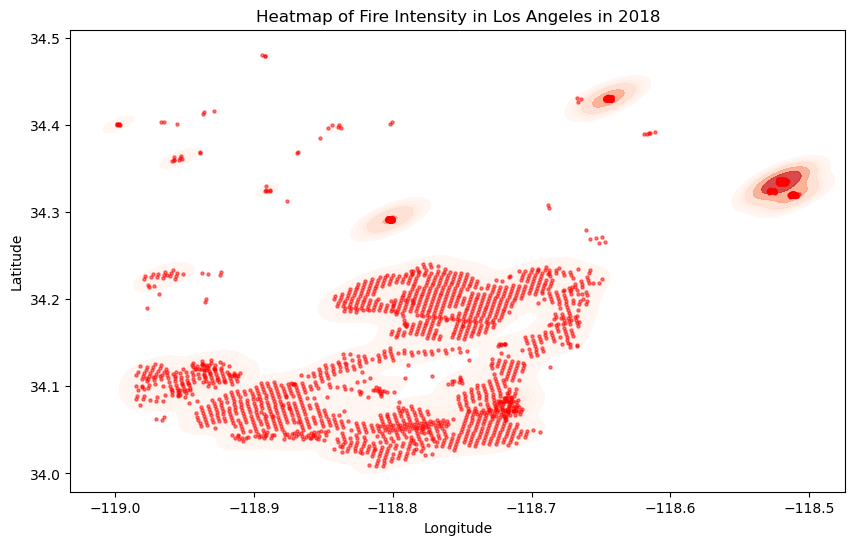

In [34]:
if not df_fires.empty:
    plt.figure(figsize=(10, 6))

    # Use kdeplot with optimized settings
    sns.kdeplot(
        x=df_fires['longitude'], 
        y=df_fires['latitude'], 
        fill=True, 
        cmap='Reds', 
        bw_adjust=0.3,  # Adjust bandwidth for better density
        alpha=0.8
    )

    # Overlay actual fire locations
    plt.scatter(df_fires['longitude'], df_fires['latitude'], color='red', s=5, alpha=0.5)

    # Titles and labels
    plt.title("Heatmap of Fire Intensity in Los Angeles in 2018")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    # Save and display
    plt.savefig("fire_intensity_heatmap.png")
    plt.show()
else:
    print("No fire data available for heatmap.")

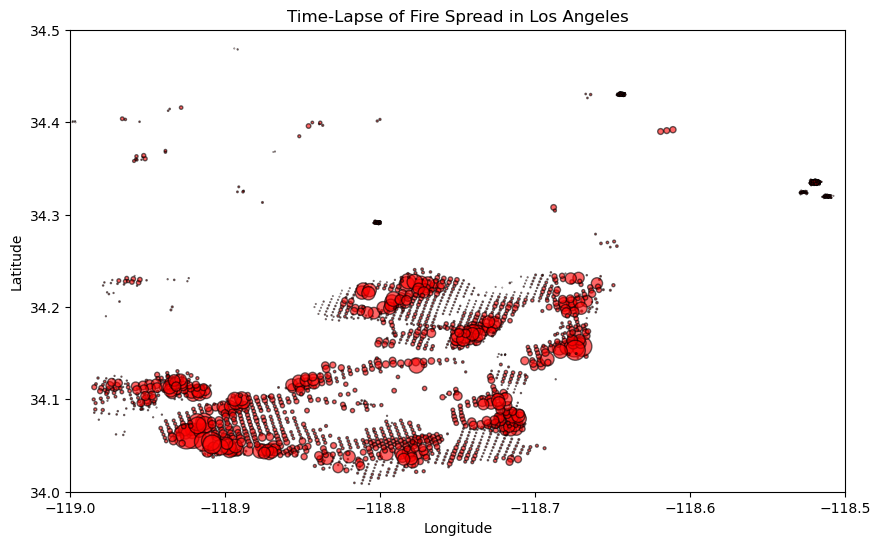

Time-lapse animation saved as 'fire_spread_timelapse.gif'


In [35]:
# Ensure 'frp' is numeric
df_fires["frp"] = pd.to_numeric(df_fires["frp"], errors="coerce")

# Drop NaN values in 'frp' to avoid multiplication errors
df_fires = df_fires.dropna(subset=["frp"])

# Time-Lapse Animation of Fire Spread
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(LA_BOUNDS["lon_min"], LA_BOUNDS["lon_max"])
ax.set_ylim(LA_BOUNDS["lat_min"], LA_BOUNDS["lat_max"])
ax.set_title("Time-Lapse of Fire Spread in Los Angeles")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
scatter = ax.scatter([], [], c='red', alpha=0.6, edgecolors='black')

def update(frame):
    current_fires = df_fires[df_fires['acq_time'] <= frame]
    scatter.set_offsets(current_fires[['longitude', 'latitude']].values)
    scatter.set_sizes(current_fires['frp'] * 0.5)  # Scale fire sizes based on FRP
    return scatter,

ani = animation.FuncAnimation(fig, update, frames=range(int(df_fires['acq_time'].min()), int(df_fires['acq_time'].max()), 10), interval=100, blit=False)
ani.save("fire_spread_timelapse.gif", writer="pillow")
plt.show()

print("Time-lapse animation saved as 'fire_spread_timelapse.gif'")


In [37]:
import folium
from folium.plugins import HeatMap

# Define the center of the map (Los Angeles)
LA_CENTER = [34.0522, -118.2437]

# Create the base map
m = folium.Map(location=LA_CENTER, zoom_start=10, tiles="cartodbpositron")

# Ensure latitude and longitude are numeric
df_fires["latitude"] = pd.to_numeric(df_fires["latitude"], errors="coerce")
df_fires["longitude"] = pd.to_numeric(df_fires["longitude"], errors="coerce")
df_fires = df_fires.dropna(subset=["latitude", "longitude"])

# Convert data to list format for HeatMap
heat_data = df_fires[["latitude", "longitude"]].values.tolist()

# Add heatmap layer
HeatMap(heat_data, radius=15, blur=10).add_to(m)

# Save and display the map
map_filename = "la_fire_heatmap.html"
m.save(map_filename)
print(f"Heatmap saved as {map_filename}")


Heatmap saved as la_fire_heatmap.html
